# LSTM - By Industry

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import datetime

In [2]:
# Import learning model dependencies
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

In [3]:
# Establish connection to AWS server
from config import db_password
import psycopg2
connection = psycopg2.connect(
    host = 'launch-it-1.cyo6pvehqvyz.us-east-1.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = db_password,
    database='launch-it-1'
    )
cursor=connection.cursor()

In [4]:
# Pull SQL dataset from database
sql = """
SELECT * FROM launchit  
"""

# Build dataframe from SQL data
stock_data = pd.read_sql(sql, con=connection)
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR
0,2022-01-26,9.83,9.830,9.83,9.830,9.830,0.0,FNVT
1,2022-01-27,9.83,9.830,9.83,9.830,9.830,0.0,FNVT
2,2022-01-28,9.83,9.830,9.83,9.830,9.830,0.0,FNVT
3,2022-01-31,9.83,9.830,9.83,9.830,9.830,300.0,FNVT
4,2022-02-01,9.86,9.915,9.83,9.855,9.855,19700.0,FNVT


In [5]:
# Pull SQL dataset from database
sql = """
SELECT * FROM launchit_info 
"""

# Build dataframe from SQL data
info_data = pd.read_sql(sql, con=connection)
info_data.head()

,TCKR,sector,industry,country,growth_rate,debtToEquity,currentRatio,forwardPE
0,MKDTY,Basic Materials,Chemicals,China,-0.671,NaN,0.928,NaN
1,INDO,Energy,Oil & Gas E&P,Indonesia,1.206,12.272,2.707,-10.130434
2,MNPR,Healthcare,Biotechnology,United States,NaN,0.228,7.614,-2.526786
3,OCFT,Technology,Software—Application,China,0.172,12.583,1.223,-3.610476
4,SPT,Technology,Software—Application,United States,0.330,16.084,1.886,-3448.500200


In [6]:
# Merge the stock_data and info_data
data_all = stock_data.merge(info_data, how='left', left_on='TCKR', right_on='TCKR')
data_all

,Date,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,industry,country,growth_rate,debtToEquity,currentRatio,forwardPE
0,2022-01-26,9.83,9.830,9.83,9.830,9.830,0.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
1,2022-01-27,9.83,9.830,9.83,9.830,9.830,0.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
2,2022-01-28,9.83,9.830,9.83,9.830,9.830,0.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
3,2022-01-31,9.83,9.830,9.83,9.830,9.830,300.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
4,2022-02-01,9.86,9.915,9.83,9.855,9.855,19700.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670042,2022-01-19,9.88,9.880,9.88,9.880,9.880,0.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
670043,2022-01-20,9.88,9.880,9.88,9.880,9.880,100.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
670044,2022-01-21,9.82,9.820,9.81,9.810,9.810,300.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN
670045,2022-01-24,9.83,9.830,9.83,9.830,9.830,437100.0,FNVT,Financial Services,Shell Companies,Cayman Islands,NaN,71.901,2.019,NaN


In [7]:
# Put the industry names in a list.
industries = pd.unique(data_all['industry']).tolist()

In [8]:
data_all = data_all.set_index(['Date' , 'industry'])
data_all

,,Open,High,Low,Close,Adj Close,Volume,TCKR,sector,country,growth_rate,debtToEquity,currentRatio,forwardPE
Date,industry,,,,,,,,,,,,,
2022-01-26,Shell Companies,9.83,9.830,9.83,9.830,9.830,0.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
2022-01-27,Shell Companies,9.83,9.830,9.83,9.830,9.830,0.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
2022-01-28,Shell Companies,9.83,9.830,9.83,9.830,9.830,0.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
2022-01-31,Shell Companies,9.83,9.830,9.83,9.830,9.830,300.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
2022-02-01,Shell Companies,9.86,9.915,9.83,9.855,9.855,19700.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,Shell Companies,9.88,9.880,9.88,9.880,9.880,0.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
2022-01-20,Shell Companies,9.88,9.880,9.88,9.880,9.880,100.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN
2022-01-21,Shell Companies,9.82,9.820,9.81,9.810,9.810,300.0,FNVT,Financial Services,Cayman Islands,NaN,71.901,2.019,NaN


In [9]:
# List all of the column names
data_all.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'TCKR', 'sector',
       'country', 'growth_rate', 'debtToEquity', 'currentRatio', 'forwardPE'],
      dtype='object')

In [10]:
# Create a new data frame grouped by Industry and taking the median of numeric values

# Make a new copy of the data_all 
industry_data = data_all.copy()

# Drop unneeded columns
industry_data = industry_data.drop(labels=['TCKR', 'sector', 'country', 'growth_rate', 'debtToEquity',
       'currentRatio', 'forwardPE'], axis=1)

# sort the data using sort_index()
industry_data.sort_index()
industry_data

,,Open,High,Low,Close,Adj Close,Volume
Date,industry,,,,,,
2022-01-26,Shell Companies,9.83,9.830,9.83,9.830,9.830,0.0
2022-01-27,Shell Companies,9.83,9.830,9.83,9.830,9.830,0.0
2022-01-28,Shell Companies,9.83,9.830,9.83,9.830,9.830,0.0
2022-01-31,Shell Companies,9.83,9.830,9.83,9.830,9.830,300.0
2022-02-01,Shell Companies,9.86,9.915,9.83,9.855,9.855,19700.0
...,...,...,...,...,...,...,...
2022-01-19,Shell Companies,9.88,9.880,9.88,9.880,9.880,0.0
2022-01-20,Shell Companies,9.88,9.880,9.88,9.880,9.880,100.0
2022-01-21,Shell Companies,9.82,9.820,9.81,9.810,9.810,300.0


In [11]:
# Group by Industry and take the median of all numeric values
# industry_data = industry_data.groupby(level='Date').median()

industry_data = industry_data.groupby(level=[0,1]).median()
industry_data

Open       High        Low  \
Date       industry                                                     
1992-05-21 Software—Infrastructure    20.000000  20.000000  17.750000   
1992-05-22 Software—Infrastructure    18.000000  18.500000  18.000000   
1992-05-26 Software—Infrastructure    18.000000  18.500000  16.500000   
1992-05-27 Software—Infrastructure    17.500000  17.500000  16.000000   
1992-05-28 Software—Infrastructure    16.500000  17.500000  16.500000   
...                                         ...        ...        ...   
2022-11-11 Utilities—Diversified      11.760000  12.575000  11.560000   
           Utilities—Regulated Gas    50.480000  54.223400  50.250000   
           Utilities—Regulated Water  16.040001  17.620001  16.204901   
           Utilities—Renewable         9.830000  10.012500   9.405000   
           Waste Management           33.585000  38.557500  36.761950   

                                          Close  Adj Close     Volume  
Date       industry                                                    
1992-05-21 Software—Infrastructure    18.000000  18.000000   248200.0  
1992-05-22 Software—Infrastructure    18.000000  18.000000    69150.0  
1992-05-26 Software—Infrastructure    17.000000  17.000000    84700.0  
1992-05-27 Software—Infrastructure    17.000000  17.000000    17300.0  
1992-05-28 Software—Infrastructure    17.000000  17.000000    40200.0  
...                                         ...        ...        ...  
2022-11-11 Utilities—Diversified      12.290000  12.290000   908535.0  
           Utilities—Regulated Gas    50.599998  50.599998  6621946.0  
           Utilities—Regulated Water  17.540001  17.540001   242921.0  
           Utilities—Renewable         9.460000   9.460000   302936.5  
           Waste Management           38.085001  38.085001  1126555.5  

[89132 rows x 6 columns]

In [12]:
industry_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [13]:
# Select one of the industries from this list
industries

['Shell Companies',
 'Diagnostics & Research',
 'Credit Services',
 'Apparel Retail',
 'REIT—Mortgage',
 'Biotechnology',
 'Medical Care Facilities',
 'Drug Manufacturers—Specialty & Generic',
 'Staffing & Employment Services',
 'Medical Devices',
 'Education & Training Services',
 'Internet Retail',
 'Utilities—Renewable',
 'Semiconductors',
 'Software—Infrastructure',
 'Healthcare Plans',
 'Utilities—Regulated Water',
 'Health Information Services',
 'Beverages—Non-Alcoholic',
 'Software—Application',
 'Restaurants',
 'Asset Management',
 'Capital Markets',
 'Telecom Services',
 'Leisure',
 'Real Estate Services',
 'Auto Manufacturers',
 'Specialty Business Services',
 'Specialty Retail',
 'Medical Instruments & Supplies',
 'Luxury Goods',
 'Packaged Foods',
 'Banks—Regional',
 'Insurance—Specialty',
 'Footwear & Accessories',
 'Information Technology Services',
 'REIT—Diversified',
 'Electronic Gaming & Multimedia',
 'Household & Personal Products',
 'Furnishings, Fixtures & Applian

In [14]:
# Isolate just 1 Industry to attempt LSTM process
df = industry_data.filter(like = 'Oil & Gas E&P', axis=0)
df

,,Open,High,Low,Close,Adj Close,Volume
Date,industry,,,,,,
2016-11-16,Oil & Gas E&P,39.750000,39.750000,38.009998,39.000000,38.913258,12600.0
2016-11-17,Oil & Gas E&P,39.000000,39.000000,35.000000,36.990002,36.907730,28300.0
2016-11-18,Oil & Gas E&P,38.950001,39.750000,34.750000,39.750000,39.661587,1100.0
2016-11-21,Oil & Gas E&P,40.000000,40.000000,35.060001,40.000000,39.911034,2500.0
2016-11-22,Oil & Gas E&P,40.000000,41.000000,36.000000,41.000000,40.908806,4100.0
...,...,...,...,...,...,...,...
2022-11-07,Oil & Gas E&P,23.309999,24.155000,22.980000,23.915000,23.915000,568600.0
2022-11-08,Oil & Gas E&P,23.989999,24.500000,23.210001,24.315001,24.315001,474150.0
2022-11-09,Oil & Gas E&P,23.974999,24.259999,23.170000,23.700001,23.700001,480900.0


In [15]:
# Reset the index
df.reset_index(inplace=True)

# Set the date column as the index
df = df.set_index('Date')
df

,industry,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2016-11-16,Oil & Gas E&P,39.750000,39.750000,38.009998,39.000000,38.913258,12600.0
2016-11-17,Oil & Gas E&P,39.000000,39.000000,35.000000,36.990002,36.907730,28300.0
2016-11-18,Oil & Gas E&P,38.950001,39.750000,34.750000,39.750000,39.661587,1100.0
2016-11-21,Oil & Gas E&P,40.000000,40.000000,35.060001,40.000000,39.911034,2500.0
2016-11-22,Oil & Gas E&P,40.000000,41.000000,36.000000,41.000000,40.908806,4100.0
...,...,...,...,...,...,...,...
2022-11-07,Oil & Gas E&P,23.309999,24.155000,22.980000,23.915000,23.915000,568600.0
2022-11-08,Oil & Gas E&P,23.989999,24.500000,23.210001,24.315001,24.315001,474150.0
2022-11-09,Oil & Gas E&P,23.974999,24.259999,23.170000,23.700001,23.700001,480900.0


1/1 [==============================] - 1s 1s/step


<AxesSubplot:title={'center':'Oil & Gas E&P'}, xlabel='Date'>

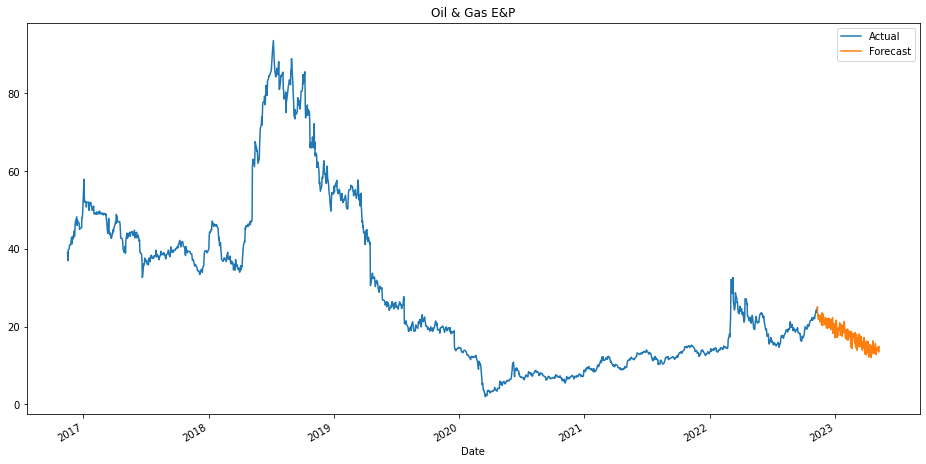

In [16]:
# download the data
y = df['Adj Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

# generate the input and output sequences
n_lookback = 365  # length of input sequences (lookback period)
n_forecast = 180  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=3, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='Oil & Gas E&P', figsize=(16,8))

In [17]:
# Create a function to run the LSTM learning model for each industry
def learning_model(df):
    # download the data
    y = df['Adj Close'].fillna(method='ffill')
    y = y.values.reshape(-1, 1)

    # scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(y)
    y = scaler.transform(y)

    # generate the input and output sequences
    n_lookback = 365  # length of input sequences (lookback period)
    n_forecast = 180  # length of output sequences (forecast period)

    X = []
    Y = []

    for i in range(n_lookback, len(y) - n_forecast + 1):
        X.append(y[i - n_lookback: i])
        Y.append(y[i: i + n_forecast])

    X = np.array(X)
    Y = np.array(Y)

    # fit the model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(n_forecast))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, Y, epochs=3, batch_size=32, verbose=0)

    # generate the forecasts
    X_ = y[- n_lookback:]  # last available input sequence
    X_ = X_.reshape(1, n_lookback, 1)

    Y_ = model.predict(X_).reshape(-1, 1)
    Y_ = scaler.inverse_transform(Y_)

    # organize the results in a data frame
    df_past = df[['Close']].reset_index()
    df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
    df_past['Date'] = pd.to_datetime(df_past['Date'])
    df_past['Forecast'] = np.nan
    df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

    df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
    df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
    df_future['Forecast'] = Y_.flatten()
    df_future['Actual'] = np.nan

    results = df_past.append(df_future).set_index('Date')
    
    # Calculate rate of return on investment based on projected future stock price
    return_rate = (results['Forecast'][-1] - df['Adj Close'][-1]) / df['Adj Close'][-1]
    
    return return_rate

    # plot the results - optional
    #results.plot(title='VIST', figsize=(16,8))

In [18]:
# Run learning_model on industry dataframe
learning_model(df)

1/1 [==============================] - 2s 2s/step


-0.4425091343822249

In [19]:
#**** Working on modifying to iterate through all industries

# # Generate unique list of industries
# unique_industries = ['TCKR'].unique()

# # Create new dataframe to house all company stock symbols and their associated growth rates
# company_roi_df = pd.DataFrame(unique_ipos, columns=['TCKR'])

# # Iterate through each unique stock symbol and filter the historical stock data for each company
# for index, ticker in company_roi_df.iterrows():
#     ticker = ticker.values[0]
#     ticker_df = stock_data[stock_data.TCKR == ticker]
    
#     # Reset the index for the filtered dataframe
#     ticker_df = ticker_df.set_index('Date')
    
#     # Run the learning model function for each company
#     company_roi_df.loc[index, 'ROI'] = learning_model(ticker_df)